In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pprint import pprint as print

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from multirotor.helpers import DataLog
from multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams, BatteryParams
from multirotor.simulation import Multirotor
from multirotor.coords import inertial_to_body
from multirotor.env import SpeedsMultirotorEnv
from multirotor.visualize import plot_datalog

import socket
import time
import json
import struct
from multirotor.coords import direction_cosine_matrix, body_to_inertial 


Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [17]:
import logging

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True

In [18]:
# Plotting/display parameters
# https://stackoverflow.com/a/21009774/4591810
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Parameters

In [19]:
# Tarot T18 params
bp = BatteryParams(max_voltage=25.2)
mp = MotorParams(
    moment_of_inertia=5e-5,
    # resistance=0.27,
    resistance=0.081,
    k_emf=0.0265,
    # k_motor=0.0932,
    speed_voltage_scaling= 0.0325,
    # speed_voltage_scaling= 0.025,
    max_current=38.
)
pp = PropellerParams(
    moment_of_inertia=1.85e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=mp #try motor = none
)
vp = VehicleParams(
    propellers=[pp] * 8,
    battery=bp,
    angles=np.array([0.5, 1.5, 0.25, 1.75, 0.75, 1.25, 1, 0])*np.pi,
    distances=np.ones(8) * 0.635,
    clockwise=[1,1,-1,-1,-1,-1,1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(dt=0.0025, g=9.81)

### Logging and Plotting

In [20]:
def clear_file(file_path):
    file_path="logs/"+file_path
    with open(file_path, 'w') as file:
        pass

In [21]:
def logToFile(string_to_log, file_path):
    file_path="logs/"+file_path
    with open(file_path, 'a') as file:
        file.write(string_to_log + '\n')

In [22]:
def printLogMotor(log, lower=0, upper=700):
    element_data = {}

    first_key = next(iter(log))
    for index in range(len(log[first_key])):
        element_data[index] = [data[index] for data in log.values()]

    plt.figure(figsize=(12, 4))

    # Plot the data for each element
    for index, data in element_data.items():
        # Filter data based on condition (value > 2000)
        filtered_data = [value if value >= lower and value <= upper else None for value in data]
        plt.plot(list(log.keys()), filtered_data, label=f"Motor {index+1}")

    # Set plot labels and title
    plt.xlabel("Frames")
    plt.ylabel("Motor command")
    plt.title("Motor Commands over time")

    # Add legend
    plt.legend(loc='upper left', fontsize='small')

    # Display the plot
    plt.show()

### AP Simulation

In [23]:
def wind(t, m):
    w_inertial = np.asarray([5 * np.sin(t * 2 * np.pi / 4000), 0, 0])
    dcm = direction_cosine_matrix(*m.orientation)
    return inertial_to_body(w_inertial, dcm)

In [24]:
def changeToJSONString(curr_time, state, accel):
    phys_time = curr_time
    pos = state[0:3].tolist()
    velo = state[3:6]
    euler = state[6:9].tolist()
    gyro = state[9:12].tolist()
    accel = accel.tolist()

    pos[2] = -1*pos[2]
    pos[0], pos[1] = pos[1], pos[0]

    dcm = direction_cosine_matrix(*euler)
    v_inertial = body_to_inertial(velo, dcm).tolist()
    v_inertial[2] = -1*v_inertial[2]
    v_inertial[0], v_inertial[1] = v_inertial[1], v_inertial[0]

    gyro[0], gyro[1] = gyro[1], gyro[0]
    gyro[2] = -1*gyro[2]
    euler[0], euler[1] = euler[1], euler[0]
    euler[2] = -1*euler[2]

    # Build JSON format
    IMU_fmt = {
        "gyro" : gyro,
        "accel_body" : accel
    }
    JSON_fmt = {
        "timestamp" : phys_time,
        "imu" : IMU_fmt,
        "position" : pos,
        "attitude" : euler,
        "velocity" : v_inertial
    }

    JSON_string = "\n" + json.dumps(JSON_fmt,separators=(',', ':')) + "\n"

    logToFile(json.dumps(JSON_fmt,separators=(',', ':')), "JSONLog.txt")

    return JSON_string


In [25]:
def ap_sim(env, sock, steps=600000, disturbance=None):
    ap_log = DataLog(env.vehicle, other_vars=("propeller_speed",))
    command_logger = {}
    accel_logger = {}
    
    disturb_force, disturb_torque = 0., 0

    curr_time = 0  # Get the current time in seconds
    RATE_HZ = 400 #should be 400
    TIME_STEP = 1/RATE_HZ
    last_frame = -1
    frame_count = 0
    frame_time = time.time()
    print_frame_count = 500

    try:
        for i in range(0, steps):
            try:   
                data, addr = sock.recvfrom(100)
                parse_format = 'HHI16H'
                magic = 18458
                if len(data) != struct.calcsize(parse_format):
                    print("got packet of len %u, expected %u" % (len(data), struct.calcsize(parse_format)))
                    continue
                unpacked_data = struct.unpack(parse_format, data)
                if magic != unpacked_data[0]:
                    print("Incorrect protocol magic %u should be %u" % (unpacked_data[0], magic))
                    continue

                frame_rate = unpacked_data[1]
                frame_count = unpacked_data[2]
                pwm = np.array(unpacked_data[3:11])

                string_action = " ".join(str(element) for element in pwm.tolist())
                logToFile(string_action, "pwmLog.txt")

                if frame_count < last_frame:
                    print('Reset controller')
                elif frame_count == last_frame:
                    print('Duplicate frame')
                    continue
                if frame_count != last_frame + 1 and last_frame != 0:
                    print("Missed %u frames" % (frame_count - last_frame))
                    continue
                last_frame = frame_count
                
                curr_time += TIME_STEP

                action = (pwm-1000)*0.575
                
                string_action = " ".join(str(element) for element in action.tolist())
                logToFile(string_action, "actionLog.txt")

                if disturbance is not None and action[0] != 0:
                    disturb_force = disturbance(i, env.vehicle)

                state, *_ = env.step(
                    action, disturb_forces=disturb_force, disturb_torques=disturb_torque
                )

                accel = env.vehicle.dxdt_speeds(0, state, action, disturb_forces=disturb_force, disturb_torques=disturb_torque)[3:6]
                accel[2] = -9.8
                if disturbance is not None:
                    accel[2] += disturb_force[2] #change accel z frame to body
                JSON_string = changeToJSONString(curr_time, state, accel)

                sock.sendto(bytes(JSON_string,"ascii"), addr)
                
                if action[0] != 0:
                    ap_log.log(propeller_speed=[p.state for p in env.vehicle.propellers])
                    command_logger[i] = action.tolist()
                    accel_logger[i] = accel.tolist()

                # Track frame rate
                if frame_count % print_frame_count == 0:
                    now = time.time()
                    total_time = now - frame_time
                    logToFile("%.2f fps T=%.3f dt=%.3f frame=%.1f rate=%d" % (print_frame_count/total_time, curr_time, total_time, frame_count, RATE_HZ), "frameLog.txt")
                    frame_time = now
            except json.JSONDecodeError:
                print("Invalid JSON data received")
            except socket.timeout:
                continue
            except KeyboardInterrupt:
                sock.close()
            except Exception as e:
                if not isinstance(e, OSError):
                    raise e
                sock.close()
                break
    finally:
        sock.close()
    
    ap_log.done_logging()   
    
    return ap_log, command_logger, accel_logger


In [26]:

UDP_IP = "127.0.0.1"  # Listen on all available interfaces
UDP_PORT = 9002

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((UDP_IP, UDP_PORT))
sock.settimeout(0.1)  # Set a timeout value of 1 second on the socket object

clear_file("frameLog.txt")
clear_file("JSONLog.txt")
clear_file("pwmLog.txt")
clear_file("actionLog.txt")
clear_file("zLog.txt")
env = SpeedsMultirotorEnv(vehicle=Multirotor(vp, sp)) # step() takes speed signals
env.reset(np.zeros(12))
ap_log, action_log, accel_log = ap_sim(env, sock, steps=600000, disturbance=None)

sock.close()

'Duplicate frame'
'Duplicate frame'
'Duplicate frame'
'Duplicate frame'
'Duplicate frame'


{'pos': <Axes: title={'center': 'Position and Orientation'}, ylabel='Orientation /deg'>,
 'vel': <Axes: title={'center': 'Velocities'}>}

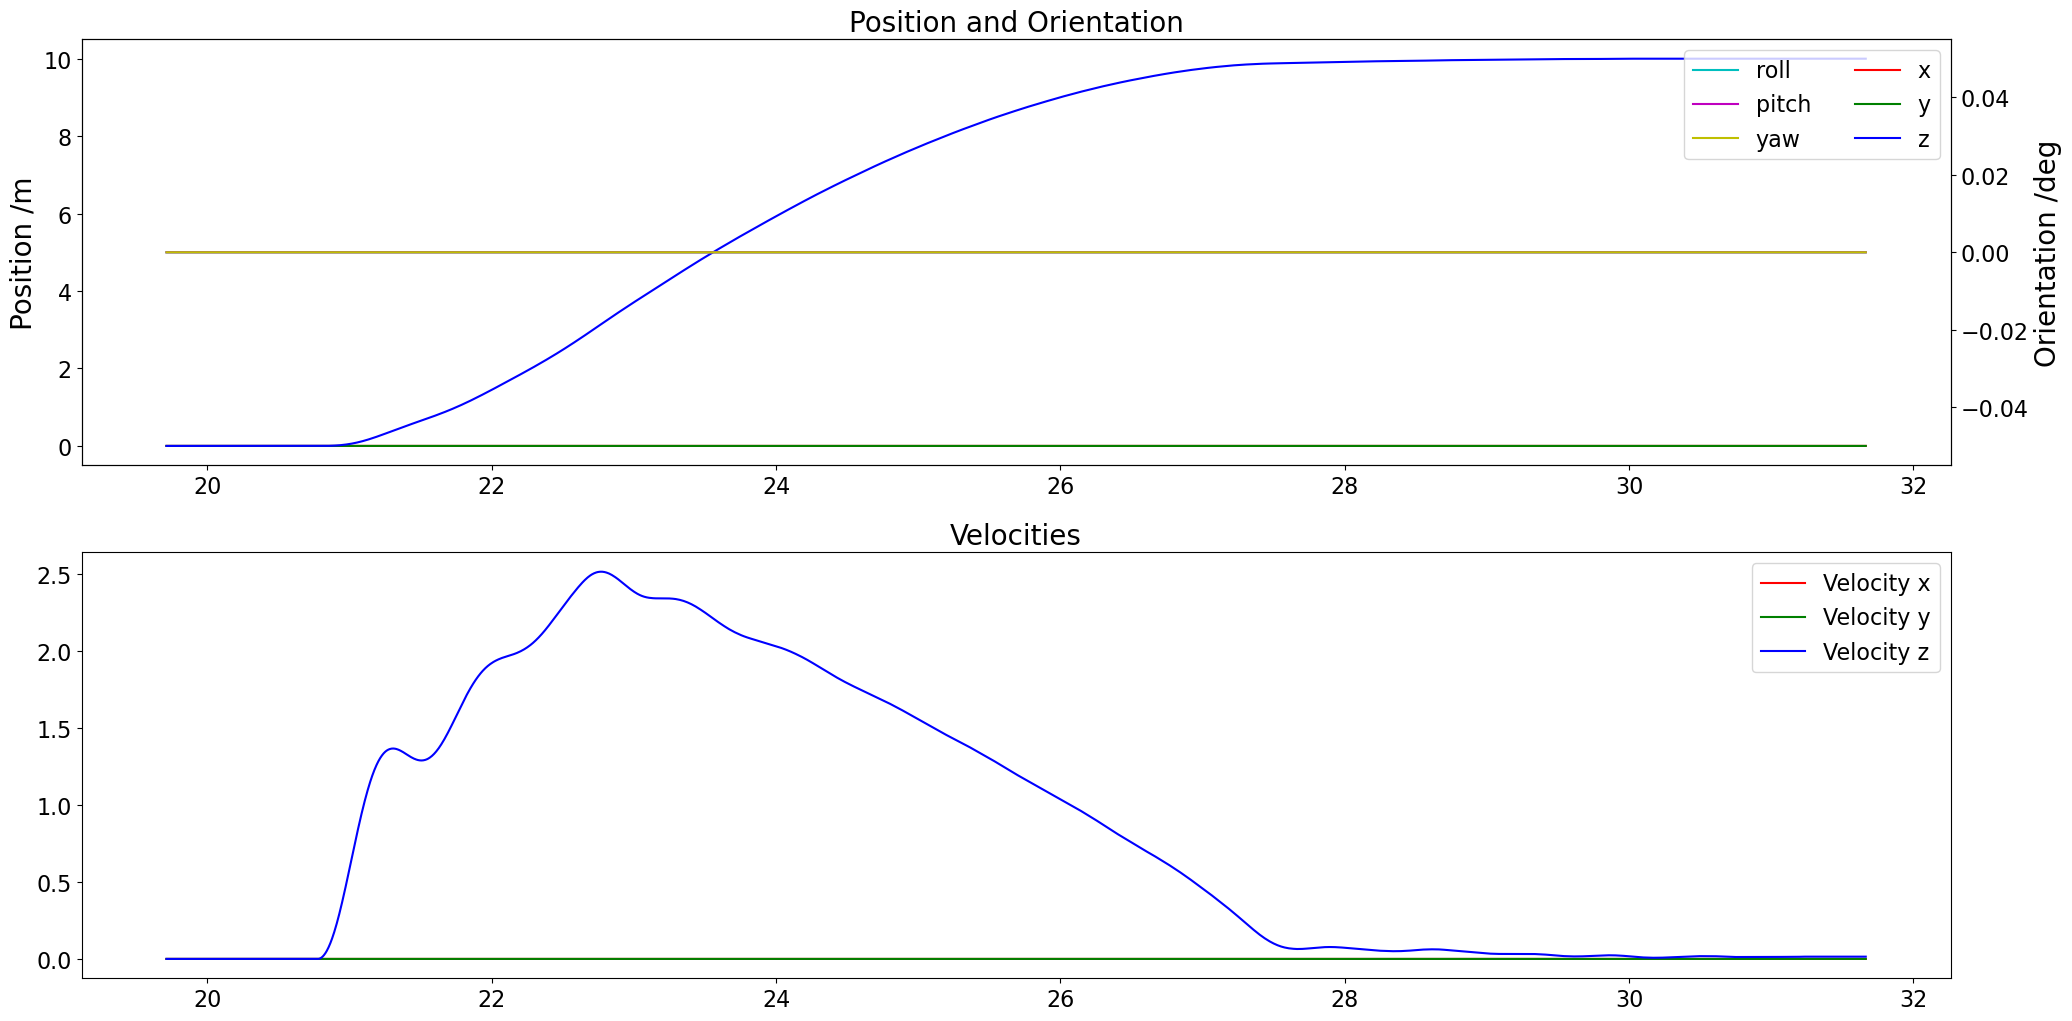

In [ ]:
plot_datalog(ap_log, plots=('pos', 'vel'))

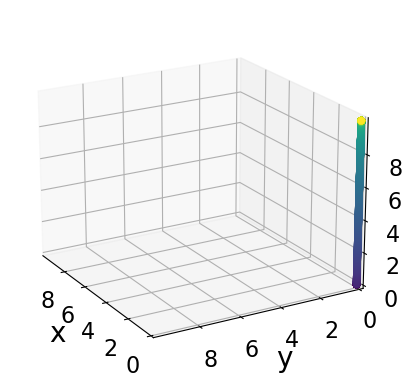

In [ ]:
fig = plt.figure()
xlim = ylim = zlim = (np.min(ap_log.position), np.max(ap_log.position))
ax = fig.add_subplot(projection='3d', xlim=xlim, ylim=ylim, zlim=zlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20,150)
ax.scatter(ap_log.x, ap_log.y, ap_log.z, c=ap_log.t)

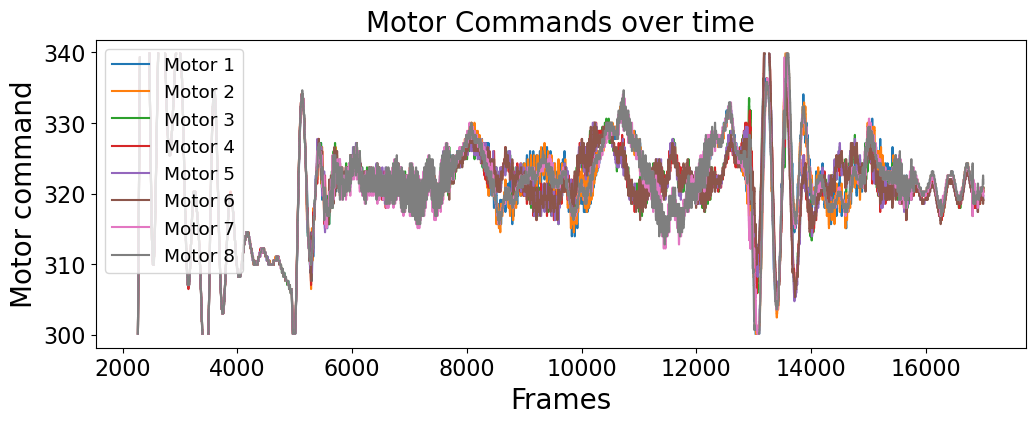

In [ ]:
printLogMotor(action_log, 300, 340)